In [ ]:
import os
import torch
import itertools
import tqdm
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import save_image
from torch.utils.data import DataLoader, random_split

In [ ]:
class LoadDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = sorted(os.listdir(root))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = Image.open(f"{self.root}/{self.images[index]}")
        w, h = img.size

        img_A = img.crop((0, 0, w / 2, h))
        img_B = img.crop((w / 2, 0, w, h))

        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")            

        if transform is not None:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return img_A, img_B

In [ ]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super().__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))

        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.down_net = nn.Sequential(*layers) 

    def forward(self, x):
        return self.down_net(x)

In [ ]:
class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super().__init__()
        layers = [nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False), 
                  nn.InstanceNorm2d(out_size), 
                  nn.ReLU(inplace=True)]

        if dropout:
            layers.append(nn.Dropout(dropout))
        self.up_net = nn.Sequential(*layers)

    def forward(self, x, skip_conn):
        x = self.up_net(x)
        return torch.cat((x, skip_conn), 1)

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(nn.Upsample(scale_factor=2), 
                                   nn.ZeroPad2d((1, 0, 1, 0)), 
                                   nn.Conv2d(128, out_channels, 4, padding=1),
                                   nn.Tanh())
        
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))

            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.d = nn.Sequential(*discriminator_block(in_channels * 2, 64, normalization=False), 
                               *discriminator_block(64, 128), 
                               *discriminator_block(128, 256), 
                               *discriminator_block(256, 512), 
                               nn.ZeroPad2d((1, 0, 1, 0)), 
                               nn.Conv2d(512, 1, 4, padding=1, bias=False))

    def forward(self, img_A, img_B):
        return self.d(torch.cat((img_A, img_B), dim=1))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 100
batch_size = 1
lr = 0.0002
b1 = 0.5
b2 = 0.999
img_size = 256
lambda_pixel = 100
patch = (1, 16, 16)

In [ ]:
device

device(type='cuda')

In [ ]:
transform = transforms.Compose([transforms.Resize((img_size, img_size), Image.BICUBIC), 
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
train_data = LoadDataset("cityscapes/train/", transform)
val_data = LoadDataset("cityscapes/val/", transform)

In [ ]:
len(train_data), len(val_data)

(2975, 500)

In [ ]:
train_batches = DataLoader(train_data, batch_size=batch_size, num_workers=8, shuffle=True)
val_batches = DataLoader(val_data, batch_size=10, num_workers=1, shuffle=True)

In [ ]:
len(train_batches), len(val_batches)

(2975, 50)

In [ ]:
img_A, img_B = train_data[42]
img_A.shape, img_B.shape

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


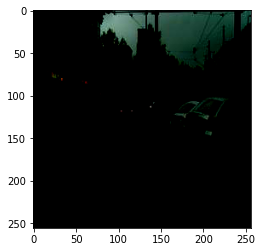

In [ ]:
plt.imshow(img_A.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


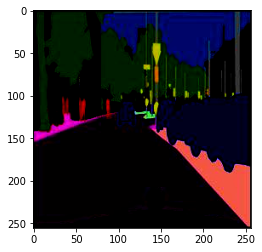

In [ ]:
plt.imshow(img_B.permute(1, 2, 0))

In [ ]:
for X, y in train_batches:
    print(X.shape)
    print(y.shape)
    break

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [ ]:
gen = Generator().to(device)
disc = Discriminator().to(device)

In [ ]:
inp = torch.randn(1, 3, 256, 256).to(device)
out = gen(inp)
out.shape, disc(out, inp).shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 1, 16, 16]))

In [ ]:
opt_g = torch.optim.Adam(gen.parameters(), lr, betas=(b1, b2))
opt_d = torch.optim.Adam(disc.parameters(), lr, betas=(b1, b2))
gan_loss_fn = nn.MSELoss()
pixel_loss_fn = nn.L1Loss()

In [ ]:
def save_fake_images(epoch):
    img_A, img_B = next(iter(val_batches))
    real_A = img_A.to(device)
    real_B = img_B.to(device)

    fake_B = gen(real_A)
    img_sample = torch.cat((real_A, fake_B, real_B), dim=-2)
    save_image(img_sample, f"segmented_images/img-{epoch}.png", nrow=5, normalize=True)

    print("fake images saved!\n")

In [ ]:
save_fake_images(0)

fake images saved!



In [ ]:
for epoch in range(epochs):
    for X, y in tqdm.tqdm(train_batches, total=len(train_batches)):
        real_A = X.to(device)
        real_B = y.to(device)

        valid = torch.ones(real_A.shape[0], *patch).to(device)
        fake = torch.zeros(real_A.shape[0], *patch).to(device)

        fake_B = gen(real_A)
        # pred_fake = disc(fake_B, real_A)
        # gan_loss = gan_loss_fn(pred_fake, valid)
        pixel_loss = pixel_loss_fn(fake_B, real_B)
        # loss_g = gan_loss + (lambda_pixel * pixel_loss)
        loss_g = pixel_loss

        opt_g.zero_grad()
        loss_g.backward()
        opt_g.step()

        pred_real = disc(real_B, real_A)
        real_loss = gan_loss_fn(pred_real, valid)
        pred_fake = disc(fake_B.detach(), real_A)
        fake_loss = gan_loss_fn(pred_fake, fake)
        loss_d = 0.5 * (real_loss + fake_loss)

        opt_d.zero_grad()
        loss_d.backward()
        opt_d.step()

    print(f" epoch: {epoch} | loss_d: {loss_d:.4f} | loss_g: {loss_g:.4f}")
    save_fake_images(epoch)

100%|██████████| 2975/2975 [03:11<00:00, 15.52it/s]

 epoch: 0 | loss_d: 0.0025 | loss_g: 0.1535



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.44it/s]

 epoch: 1 | loss_d: 0.0021 | loss_g: 0.0701



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.43it/s]

 epoch: 2 | loss_d: 0.0007 | loss_g: 0.0702



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.44it/s]

 epoch: 3 | loss_d: 0.0044 | loss_g: 0.1826



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.45it/s]

 epoch: 4 | loss_d: 0.0030 | loss_g: 0.0821



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.45it/s]

 epoch: 5 | loss_d: 0.0002 | loss_g: 0.0707



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.45it/s]

 epoch: 6 | loss_d: 0.0012 | loss_g: 0.1065



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.45it/s]

 epoch: 7 | loss_d: 0.0005 | loss_g: 0.0505



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.46it/s]

 epoch: 8 | loss_d: 0.0003 | loss_g: 0.0812



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.46it/s]

 epoch: 9 | loss_d: 0.0002 | loss_g: 0.0819



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.44it/s]

 epoch: 10 | loss_d: 0.0005 | loss_g: 0.0771



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.43it/s]

 epoch: 11 | loss_d: 0.0002 | loss_g: 0.0868



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.44it/s]

 epoch: 12 | loss_d: 0.0004 | loss_g: 0.0860



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.46it/s]

 epoch: 13 | loss_d: 0.0003 | loss_g: 0.0992



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.45it/s]

 epoch: 14 | loss_d: 0.0021 | loss_g: 0.0826



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.47it/s]

 epoch: 15 | loss_d: 0.0002 | loss_g: 0.0744



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.47it/s]

 epoch: 16 | loss_d: 0.0003 | loss_g: 0.0570



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.45it/s]

 epoch: 17 | loss_d: 0.0005 | loss_g: 0.0789



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.46it/s]

 epoch: 18 | loss_d: 0.0023 | loss_g: 0.0886



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.46it/s]

 epoch: 19 | loss_d: 0.0024 | loss_g: 0.0733



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.44it/s]

 epoch: 20 | loss_d: 0.0003 | loss_g: 0.0767



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.45it/s]

 epoch: 21 | loss_d: 0.0003 | loss_g: 0.2075



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.45it/s]

 epoch: 22 | loss_d: 0.0008 | loss_g: 0.0638



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.47it/s]

 epoch: 23 | loss_d: 0.0002 | loss_g: 0.0796



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.47it/s]

 epoch: 24 | loss_d: 0.0002 | loss_g: 0.1158



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.45it/s]

 epoch: 25 | loss_d: 0.0002 | loss_g: 0.1414



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.46it/s]

 epoch: 26 | loss_d: 0.0002 | loss_g: 0.0613



  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.45it/s]

 epoch: 27 | loss_d: 0.0001 | loss_g: 0.0380
 epoch: 27 | loss_d: 0.0001 | loss_g: 0.0380




  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.44it/s]

 epoch: 28 | loss_d: 0.0007 | loss_g: 0.0984
 epoch: 28 | loss_d: 0.0007 | loss_g: 0.0984




  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.44it/s]

 epoch: 29 | loss_d: 0.0002 | loss_g: 0.0393
 epoch: 29 | loss_d: 0.0002 | loss_g: 0.0393




  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.45it/s]

 epoch: 30 | loss_d: 0.0002 | loss_g: 0.0841
 epoch: 30 | loss_d: 0.0002 | loss_g: 0.0841




  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.45it/s]

 epoch: 31 | loss_d: 0.0001 | loss_g: 0.0522
 epoch: 31 | loss_d: 0.0001 | loss_g: 0.0522




  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.46it/s]

 epoch: 32 | loss_d: 0.0002 | loss_g: 0.0744
 epoch: 32 | loss_d: 0.0002 | loss_g: 0.0744




  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.46it/s]

 epoch: 33 | loss_d: 0.0015 | loss_g: 0.0726
 epoch: 33 | loss_d: 0.0015 | loss_g: 0.0726




  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!

fake images saved!



100%|██████████| 2975/2975 [03:12<00:00, 15.46it/s]

 epoch: 34 | loss_d: 0.0001 | loss_g: 0.0716
 epoch: 34 | loss_d: 0.0001 | loss_g: 0.0716




  0%|          | 0/2975 [00:00<?, ?it/s]

fake images saved!

fake images saved!



 54%|█████▎    | 1597/2975 [01:43<01:29, 15.42it/s]

KeyboardInterrupt: ignored

KeyboardInterrupt: ignored

In [ ]:
def save_checkpoint(net, filename):
    check_point = {"net_dict": net.state_dict()}
    torch.save(check_point, filename)
    print("Checkpoint Saved!")

def load_checkpoint(net, filename):
    check_point = torch.load(filename)
    net.load_state_dict(check_point["net_dict"])
    print("Checkpoint Loaded!")

In [ ]:
save_checkpoint(gen, "gen.pth.tar")

Checkpoint Saved!
